#### Universidad Galileo
#### Ciencia de Datos en Python 

#### Proyecto: Ingenieria de Datos en Python 

Integrantes: <br>
    Salvador Antonio Recinos Diaz <br>
    Alejandra Ma. Ubico Melgar 

# Amazon Sales 

### Dataset

El dataset seleccionado describe las ventas que ha tenido la empresa de Amazon durante 3 meses del año 2022. Los campos que conforman este dataset serán descritos posteriormente para un mejor entendimiento.

### Campos en el dataset <br>
+ Order id: es el numero de la transaccion realizada, este numero es único y nos ayuda a identificar cada transacción 
+ Date: nos indica la fecha en la cual se realizo el pedido
+ Status: nos brinda el estado del proceso de venta 
+ Sullfiment: nos dice quien da el cumplimiento 
+ Sales channel: nos indica el canal por el cual se ha realizado la venta
+ Ship-service-level: nos indica el tipo de shipping con el cual se ha enviado un producto
+ Style=: describe con un codigo único el estilo del producto
+ SKU: el codigo único de cada producto
+ Category: nos dice a que categoria pertenece cada producto 
+ Size: nos dice el tamaño del producto
+ ASIN: Es el numero estandar de identificacion de amazon
+ Courier status : nos dice el estado del procesos del courier 
+ QTY: Cantidad de los productos que llevan cada orden
+ Currency: nos dice el tipo de divisa
+ Amount:  es el monto gastado 
+ Ship-City: la ciudad a donde se envía el producto
+ Ship-state: el estado a donde se envía el producto
+ Ship-postal-code: el codigo postal del lugar a donde se envía
+ Ship-country: país a donde se envia el producto
+ Promotion-ids:es el codigo de descuento que han presentado en la compra.
+ B2B: nos indica si la compra ha sido business to business.

### Descripción del problema a resolver

El objetivo principal del proyecto será crear un Data Warehouse, el cual ayudará a manejar la información de las ventas
de una forma más ordenada y más eficaz. Teniendo el Data Warehouse, Amazaon tendrá una estructura en sus datos que le permitirá  visualizar de manera mas rápida y sencilla sus ventas de forma detallada. 

Además la incorporación de este proyecto ayudará a Amazon a crear tableros en programas como: Power BI, Tableau,etc.
esto con el fin de identificar KPIS, alertas ,etc. lo cual hace que la información sea de facil entedimiento para los usuarios finales

### Necesidad del proyecto

La necesidad del proyecto surge del tamaño de los datos que se tienen en la empresa de Amazon. Con tantos registros es dificil el procesamiento de datos, los calculos de datos y la extraccón de la información. Con la implementacion de un Data Warehouse los procesos de limpieza, carga, transformación de datos se automatizan y ahorran tiempo importante dentro de la empresa.

El tener la información a la mano se ha vuelto una necesidad indispensable en las empresas grandes y Amazon no es la excepción. Entonces la implementacion de un Data Warehouse nos permitirá crear tableros con ayuda de otras aplicaciones para observar el comportamientos de las ventas de forma instantánea el cual ayudará a tomar decisiones importantes si se ven endencias claras o anomalias en los datos.

### Para quien va dirigido este proyecto

+ Analistas de BI: <br>
Los analista se encargaran de tomar los datos del Data Warehouse y transformarlos en KPIS e insights que sirvan a la toma de decisiones. 
+ Gerentes: <br>
Los gerentes se beneficiarán del Data Warehouse con ayuda de los analistas al generar tableros de facil entendimiento que ayuden a generar información valiosa para la toma de decisiones.

### Como se hará el proyecto

El proyecto se realizará en Python y en AWS. Acá es donde se realizarán los procesos de extracción, transformación y carga de datos, el modelado del Data Warehouse se realizará en Python.

Todo esto se hará por medio de código que quedará documentado en forma de scripts.

## Analitica

Una vez creado el DW con la informacion que transformamos e insertamos en la base de datos se busca contestar las siguientes incognitas del negocio: <br>

1. ¿Cuales son los productos que más venta han generado? <br>			
2. ¿Cuál es el  mejor mes en ventas a lo largo del tiempo? <br>				
3. ¿Cuál lugar es donde nos compran más productos? <br>	
4. ¿Cuál canal de ventas genera mas ingresos? <br>	
5. ¿Cuáles son los top 3 categorias de productos  con mas ventas? <br>
6. Los productos que son cancelados con mayor frecuencia. 	

## Modelo Relacional

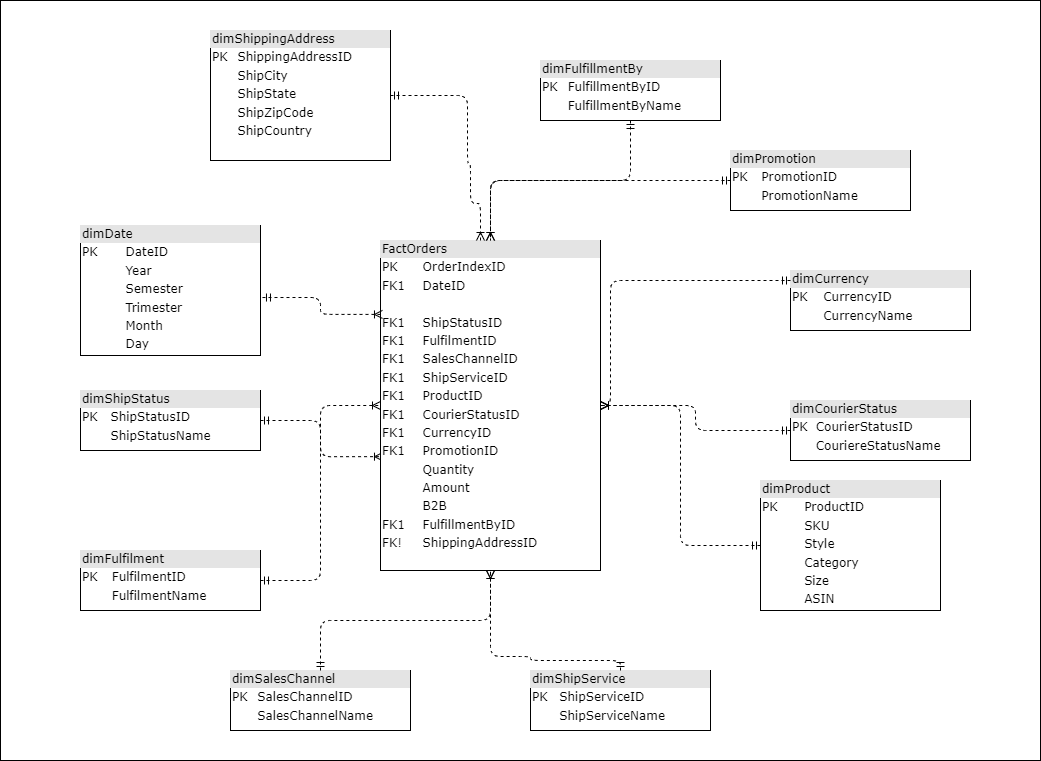

## Procesamiento

In [298]:
import pandas as pd
import numpy as np
import boto3
import configparser
import sys
import psycopg2
import io
import warnings

In [299]:
config = configparser.ConfigParser()
config.read('escec.cfg')

['escec.cfg']

### Lectura de Archivo desde S3

In [300]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)

In [301]:
for bucket in s3.buckets.all():
    S3_BUCKET_NAME = bucket.name
    print(bucket.name)

aubico


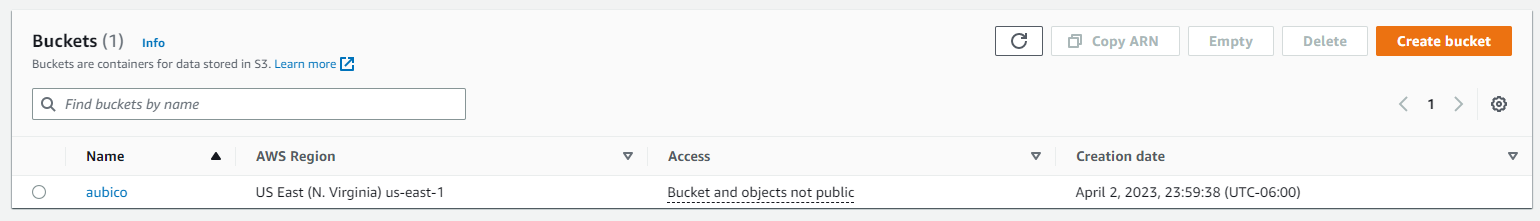

In [302]:
remoteFileList = []
for objt in s3.Bucket(S3_BUCKET_NAME).objects.all():
    remoteFileList.append(objt.key)

remoteFileList

['202203.csv', 'dimStatus.csv']

In [303]:
for remoteFile in remoteFileList:
   try:
       file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
       if('.csv' in remoteFile):
           
           #catalogo Estados/Status
           if('dimStatus' in remoteFile):
               global dimStatuscsv
               dimStatuscsv = pd.read_csv(file['Body'])
               dimStatuscsv.to_csv(remoteFile, index=False)

            #archivo mes en curso a procesar
           else:
                print(remoteFile)
                archivoCsv= pd.read_csv(file['Body'])
                archivoCsv.to_csv(remoteFile, index=False)
       else:
           data = file['Body'].read()
           archivoExcel= pd.read_excel(io.BytesIO(data), engine='openpyxl')
           archivoExcel.to_excel(remoteFile, index=False)
   except Exception as ex:
       print("No es un archivo.")
       print(ex)


202203.csv


### Creacion de la Instancia 

In [313]:
config = configparser.ConfigParser()
config.read('escec.cfg')

['escec.cfg']

In [314]:
aws_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                    aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'),
                    region_name='us-east-1')
print(aws_conn)

In [315]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds []


In [316]:
rdsIdentifier = 'Amazondw-db'

try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('RDS_MYSQL', 'DB_NAME'),
            DBInstanceIdentifier=rdsIdentifier,
            DBInstanceClass="db.t3.micro",
            Engine="mysql",
            MasterUsername=config.get('RDS_MYSQL', 'DB_USER'),
            MasterUserPassword=config.get('RDS_MYSQL', 'DB_PASSWORD'),
            Port=int(config.get('RDS_MYSQL', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True
        )
    print('Instancia creada exitosamente. Estara disponible en unos minutos.')
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

Instancia creada exitosamente. Estara disponible en unos minutos.


### Creacion del DataWarehouse

In [318]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifier)
     RDS_DW_HOST = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_DW_HOST)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

amazondw-db.cadsisdqg9ad.us-east-1.rds.amazonaws.com


### Creacion de tablas de dimensiones

In [320]:
import mysql.connector as mysqlC
import importlib as implib
import create_dw_query

implib.reload(create_dw_query)

try:
    myDw = mysqlC.connect(
    host=RDS_DW_HOST, 
    user=config.get('RDS_MYSQL', 'DB_USER'),
    password=config.get('RDS_MYSQL', 'DB_PASSWORD'),
    database=config.get('RDS_MYSQL', 'DB_NAME')
    )
 
    mycursor = myDw.cursor()
    for i in mycursor.execute(create_dw_query.CREATE_DW,multi=True):
        True
    mycursor.close()
    myDw.commit()
    print("Dimensiones y Tabla de Hechos Creadas Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Dimensiones y Tabla de Hechos Creadas Exitosamente


#### Datawarehouse Creado

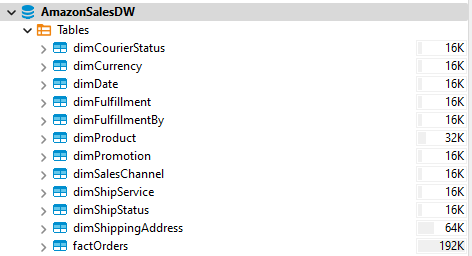

### Modificacion e Insercion de datos a las dimensiones 

In [321]:
import pymysql
mysql_driver = f"""mysql+pymysql://{config.get('RDS_MYSQL', 'DB_USER')}:{config.get('RDS_MYSQL', 'DB_PASSWORD')}@{RDS_DW_HOST}:{config.get('RDS_MYSQL', 'DB_PORT')}/{config.get('RDS_MYSQL', 'DB_NAME')}"""

In [277]:
# funcion para insertar datos a las dimensiones similares (codigo, nombre)
import mysql.connector as mysqlC
import importlib as implib

def dimensiones (dfA, dimid, dimnombre, columna, tabla):
    global dfdimfact
    dfdim = dfA[[columna]]

    dfdim.drop_duplicates(inplace=True)
    dfdim.reset_index(inplace=True, drop=True)
    dfdim.reset_index(inplace=True)

    dfdim.rename(columns={columna:dimnombre,'index':dimid},inplace=True)
    dfdim.to_sql(tabla, mysql_driver, index=False, if_exists='append')
    dfdimfact = dfdim
    return dfdimfact

In [221]:

warnings.filterwarnings('ignore')

dimensiones(dfAmazon, 'FulfillmentID','FulfillmentName','Fulfilment','dimFulfillment')
dfFulfillment = dfdimfact
dimensiones(dfAmazon, 'SalesChannelID','SalesChannelName','Sales Channel ','dimSalesChannel')
dfSalesChannel = dfdimfact
dimensiones(dfAmazon, 'ShipServiceID','ShipServiceName','ship-service-level','dimShipService')
dfShipService = dfdimfact
dimensiones(dfAmazon, 'CourierStatusID','CourierStatusName','Courier Status','dimCourierStatus')
dfCourierStatus = dfdimfact
dimensiones(dfAmazon, 'CurrencyID','CurrencyName','currency','dimCurrency')
dfCurrency = dfdimfact
dimensiones(dfAmazon, 'PromotionID','PromotionName','promotion-ids','dimPromotion')
dfPromotion = dfdimfact
dimensiones(dfAmazon, 'FulfillmentByID','FulfillmentByName','fulfilled-by','dimFufillmentBy')
dfFulfillmentBy = dfdimfact

C:\Users\aleu_\AppData\Local\Temp\ipykernel_14636\2122552540.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfdim.drop_duplicates(inplace=True)
C:\Users\aleu_\AppData\Local\Temp\ipykernel_14636\2122552540.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfdim.rename(columns={columna:dimnombre,'index':dimid},inplace=True)
C:\Users\aleu_\AppData\Local\Temp\ipykernel_14636\2122552540.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [97]:
warnings.filterwarnings('ignore')

# dim product 
dfproduct = dfAmazon[['SKU','Style','Category','Size','ASIN']]

dfproduct.drop_duplicates(inplace=True)
dfproduct.reset_index(inplace=True, drop=True)
dfproduct.reset_index(inplace=True)

dfproduct.rename(columns={'index':'ProductID'}, inplace=True)
# dfproduct.head()
dfproduct.to_sql('dimProduct', mysql_driver, index=False, if_exists='append')


C:\Users\aleu_\AppData\Local\Temp\ipykernel_14636\2027874816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfproduct.drop_duplicates(inplace=True)
C:\Users\aleu_\AppData\Local\Temp\ipykernel_14636\2027874816.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfproduct.rename(columns={'index':'ProductID'}, inplace=True)


149

In [149]:
warnings.filterwarnings('ignore')

# dim date 
dimDate = dfAmazon[['Date']]
dimDate.drop_duplicates(inplace=True)

dimDate['Year'] = pd.DatetimeIndex(dimDate['Date']).year
dimDate['Trimester'] = pd.DatetimeIndex(dimDate['Date']).quarter
dimDate['Month'] = pd.DatetimeIndex(dimDate['Date']).month
dimDate['Day'] = pd.DatetimeIndex(dimDate['Date']).day

if pd.DatetimeIndex(dimDate['Date']).quarter in (1,2):
    dimDate['Semester'] = 1
else: 
    dimDate['Semester'] = 2

dimDate['Date'] = pd.to_datetime(dimDate['Date'])

dimDate.rename(columns={'Date':'DateID'}, inplace=True)
dimDate.to_sql('dimDate', mysql_driver, index=False, if_exists='append')

C:\Users\aleu_\AppData\Local\Temp\ipykernel_14636\3421972759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dimDate.drop_duplicates(inplace=True)
C:\Users\aleu_\AppData\Local\Temp\ipykernel_14636\3421972759.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dimDate['Year'] = pd.DatetimeIndex(dimDate['Date']).year
C:\Users\aleu_\AppData\Local\Temp\ipykernel_14636\3421972759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

1

In [103]:
warnings.filterwarnings('ignore')

# dim shipping address
dfshipaddress = dfAmazon[['ship-city','ship-state','ship-postal-code','ship-country']]

dfshipaddress.drop_duplicates(inplace=True)
dfshipaddress.reset_index(inplace=True, drop=True)
dfshipaddress.reset_index(inplace=True)

dfshipaddress.rename(columns={'index':'ShippingAddressID',
                              'ship-city':'ShipCity',
                              'ship-state':'ShipState',
                              'ship-postal-code':'ShipZipCode',
                              'ship-country':'ShipCountry'}, 
                     inplace=True)
#dfshipaddress
dfshipaddress.to_sql('dimShippingAddress', mysql_driver, index=False, if_exists='append')

C:\Users\aleu_\AppData\Local\Temp\ipykernel_14636\3840403230.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfshipaddress.drop_duplicates(inplace=True)
C:\Users\aleu_\AppData\Local\Temp\ipykernel_14636\3840403230.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfshipaddress.rename(columns={'index':'ShippingAddressID',


141

### Modificacion e Insercion de datos a la tabla de hechos

In [246]:
dfFact = dfAmazon
dfFact['OrderIndexID'] = dfFact['Order ID'].astype(str) +  "-" + dfFact['index'].astype(str)
dfFact = dfFact.drop(['index','Order ID'], axis=1)

dfFact = pd.merge(dfFact, dfShipStatus, left_on= 'Status', right_on='ShipStatusName',how='outer', left_index=False, right_index=False)
dfFact = dfFact.drop(['Status','ShipStatusName'], axis=1)

dfFact = pd.merge(dfFact, dfFulfillment, left_on= 'Fulfilment', right_on='FulfillmentName',how='outer', left_index=False, right_index=False)
dfFact = dfFact.drop(['Fulfilment','FulfillmentName'], axis=1)

dfFact = pd.merge(dfFact, dfSalesChannel, left_on= 'Sales Channel ', right_on='SalesChannelName',how='outer', left_index=False, right_index=False)
dfFact = dfFact.drop(['Sales Channel ','SalesChannelName'], axis=1)

dfFact = pd.merge(dfFact, dfShipService, left_on= 'ship-service-level', right_on='ShipServiceName',how='outer', left_index=False, right_index=False)
dfFact = dfFact.drop(['ship-service-level','ShipServiceName'], axis=1)

dfFact = pd.merge(dfFact, dfCourierStatus, left_on= 'Courier Status', right_on='CourierStatusName',how='outer', left_index=False, right_index=False)
dfFact = dfFact.drop(['Courier Status','CourierStatusName'], axis=1)

dfFact = pd.merge(dfFact, dfCurrency, left_on= 'currency', right_on='CurrencyName',how='outer', left_index=False, right_index=False)
dfFact = dfFact.drop(['currency','CurrencyName'], axis=1)

dfFact = pd.merge(dfFact, dfPromotion, left_on= 'promotion-ids', right_on='PromotionName',how='outer', left_index=False, right_index=False)
dfFact = dfFact.drop(['promotion-ids','PromotionName'], axis=1)

dfFact = pd.merge(dfFact, dfFulfillmentBy, left_on= 'fulfilled-by', right_on='FulfillmentByName',how='outer', left_index=False, right_index=False)
dfFact = dfFact.drop(['fulfilled-by','FulfillmentByName'], axis=1)

dfFact = pd.merge(dfFact, dfproduct, left_on= 'ASIN', right_on='ASIN',how='outer', left_index=False, right_index=False)
dfFact = dfFact.drop(['Style_x','SKU_x','Category_x','Size_x','SKU_y','Style_y','Category_y','Size_y','ASIN'], axis=1)

dfFact = pd.merge(dfFact, dfshipaddress, left_on=['ship-city','ship-state','ship-postal-code','ship-country'], 
                  right_on=['ShipCity','ShipState','ShipZipCode','ShipCountry'],how='outer', 
                  left_index=False, right_index=False)
dfFact = dfFact.drop(['ship-city','ship-state','ship-postal-code','ship-country','ShipCity','ShipState','ShipZipCode','ShipCountry'], axis=1)

dfFact = pd.merge(dfFact, dimDate, left_on= 'Date', right_on='DateID',how='outer', left_index=False, right_index=False)
dfFact = dfFact.drop(['Date'], axis=1)

ValueError: You are trying to merge on object and datetime64[ns] columns. If you wish to proceed you should use pd.concat

In [245]:
dfFact.head()

,Date,Qty,Amount,B2B,OrderIndexID,ShipStatusID,FulfillmentID,SalesChannelID,ShipServiceID,CourierStatusID,CurrencyID,PromotionID,FulfillmentByID,ProductID,ShippingAddressID
0,3/31/2022,1,453.00,False,171-7326790-9044369-48879,0,0,0,0,0,0,0,0,0,0
1,3/31/2022,1,353.00,False,171-7326790-9044369-48880,0,0,0,0,0,0,0,0,1,0
2,3/31/2022,0,360.95,False,171-7192082-3049169-48881,1,1,0,1,1,0,1,1,2,0
3,3/31/2022,1,688.00,False,405-1392423-9557138-48883,0,0,0,0,0,0,0,0,4,2
4,3/31/2022,1,1496.00,False,407-7904992-8992306-48884,0,0,0,0,0,0,0,0,5,3


In [162]:
dfAmazon.columns

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by'],
      dtype='object')